# Imports

## Standards

In [26]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pprint import pprint

%matplotlib inline

## Machine Learning

### Preprocessing

In [171]:
# base
from sklearn.base import TransformerMixin, BaseEstimator

# pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

# compose
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
    PolynomialFeatures,
    OneHotEncoder,
)

# feature selection
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectPercentile,
    mutual_info_classif,
    f_classif,
    chi2
)

# decomposition
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA

# manifold
from sklearn.manifold import Isomap, TSNE, MDS, SpectralEmbedding

### Modeling

In [3]:
# cluster
from sklearn.cluster import OPTICS, AffinityPropagation, AgglomerativeClustering, DBSCAN, KMeans, MeanShift

# ensemble
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)

# logistic regression
from sklearn.linear_model import LogisticRegression, SGDClassifier

# naive bayes
from sklearn.naive_bayes import MultinomialNB

# process classifier
from sklearn.gaussian_process import GaussianProcessClassifier

# neighbors
from sklearn.neighbors import KNeighborsClassifier

# neural networks
from sklearn.neural_network import MLPClassifier

# support vector machines
from sklearn.svm import LinearSVC, SVC

# multiclass
from sklearn.multiclass import OneVsRestClassifier

# train test split, tuning, and score validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# classification report
from sklearn.metrics import classification_report, confusion_matrix

# Data

In [4]:
# read training data
train = pd.read_csv("train.csv")

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             371 non-null    int64  
 1   bone_length    371 non-null    float64
 2   rotting_flesh  371 non-null    float64
 3   hair_length    371 non-null    float64
 4   has_soul       371 non-null    float64
 5   color          371 non-null    object 
 6   type           371 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [6]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [7]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


# Goal
Predict `type` of creature.

In [8]:
train.type.value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [9]:
train.set_index('id', inplace=True)

X = train.drop(columns='type')
y = train.type

X_obj = X.select_dtypes(include=['O'])

X_num = X.select_dtypes(exclude=['O'])

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

ohe_obj = ohe.fit_transform(X_obj)

X_obj = pd.DataFrame(
    data=ohe_obj,
    index=X_obj.index,
    columns=ohe.get_feature_names(X_obj.columns)
)

X = X_num.join(X_obj)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

In [172]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures()),
    ('scale', MinMaxScaler()),
    ('var', VarianceThreshold()),
    ('select', SelectPercentile()),
    ('clf', GradientBoostingClassifier(random_state=0))
])

In [178]:
params_pre = {
    'poly__degree' : stats.randint(2, 6),
    'poly__interaction_only' : [True, False],
    'poly__include_bias' : [True, False],
    'scale' : [
        MinMaxScaler(),
        QuantileTransformer(output_distribution='uniform', ignore_implicit_zeros=False, random_state=0),
        QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False, random_state=0),
        QuantileTransformer(output_distribution='uniform', ignore_implicit_zeros=True, random_state=0),
        QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=True, random_state=0),
    ],
    'var__threshold' : stats.uniform(0, 0.04),
    'select__score_func' : [f_classif, chi2, mutual_info_classif],
    'select__percentile' : stats.randint(10, 100),
}

params = [
#     {
#         **params_pre,
#         'clf' : [GradientBoostingClassifier(loss = "deviance", random_state=0)],
#         'clf__learning_rate' : stats.uniform(0.1, 1),
#         'clf__n_estimators' : stats.randint(100, 1000),
#         'clf__subsample' : stats.uniform(0, 1),
#         'clf__criterion' : ['friedman_mse', 'mse', 'mae',],
#         'clf__min_samples_split' : stats.uniform(0, 0.5),
#         'clf__min_samples_leaf' : stats.uniform(0, 0.5),
#         'clf__min_weight_fraction_leaf' : stats.uniform(0, 0.5),
#         'clf__max_depth' : stats.randint(3, 50),
#         'clf__min_impurity_decrease' : stats.uniform(0, 0.5),
#         'clf__max_features' : ['sqrt', 'log2', None],
#         'clf__warm_start' : [True, False],
#         'clf__validation_fraction' : stats.uniform(0.1, 0.2),
#         'clf__n_iter_no_change' : stats.randint(0, 10),
#         'clf__tol' : stats.uniform(1e-4, 1e-1),
#         'clf__ccp_alpha' : stats.uniform(0, 1)
#     },
#     {
#         **params_pre,
#         'clf' : [AdaBoostClassifier(random_state=0)],
#         'clf__n_estimators' : stats.randint(50, 1000),
#         'clf__learning_rate' : stats.uniform(0.5, 1.5),
#         'clf__algorithm' : ['SAMME', 'SAMME.R'],
#     },
    {
        **params_pre,
        'clf' : [OneVsRestClassifier(AdaBoostClassifier(random_state=0), n_jobs=-1)],
        'clf__estimator__n_estimators' : stats.randint(50, 1000),
        'clf__estimator__learning_rate' : stats.uniform(0.5, 1.5),
        'clf__estimator__algorithm' : ['SAMME', 'SAMME.R'],
    }
]

ada_rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params,
    n_iter=10,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

In [179]:
ada_rscv.fit(X_train, y_train)
print(f"Best Params")
print('-'*77)
print()
pprint(ada_rscv.best_params_)
print()
print('-'*77)
print()
print(f"Best Training Score: {ada_rscv.best_score_}")
print()
print('-'*77)
print()
print(f"Training Score: {ada_rscv.score(X_train, y_train)}")
print()
print(classification_report(y_train, ada_rscv.predict(X_train)))
print()
print('-'*77)
print()
print(f"Validation Score: {ada_rscv.score(X_validate, y_validate)}")
print()
print(classification_report(y_validate, ada_rscv.predict(X_validate)))
print()
print('-'*77)
print()
print(f"Test Score: {ada_rscv.score(X_test, y_test)}")
print()
print(classification_report(y_test, ada_rscv.predict(X_test)))
print()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished


Best Params
-----------------------------------------------------------------------------

{'clf': OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=0.6306939495523111,
                                                 n_estimators=165,
                                                 random_state=0),
                    n_jobs=-1),
 'clf__estimator__algorithm': 'SAMME',
 'clf__estimator__learning_rate': 0.6306939495523111,
 'clf__estimator__n_estimators': 165,
 'poly__degree': 2,
 'poly__include_bias': False,
 'poly__interaction_only': False,
 'scale': MinMaxScaler(),
 'select__percentile': 92,
 'select__score_func': <function f_classif at 0x7f6a2e62ddd0>,
 'var__threshold': 0.03203643007918577}

-----------------------------------------------------------------------------

Best Training Score: 0.684795321637427

-----------------------------------------------------------------------------

Training Score:

In [183]:
ada_cv_results = pd.DataFrame(ada_rscv.cv_results_)

param_cols = ada_cv_results.columns[ada_cv_results.columns.str.contains('param')]

split_cols = ada_cv_results.columns[ada_cv_results.columns.str.contains('split')]

time_cols = ada_cv_results.columns[ada_cv_results.columns.str.contains('time')]

test_cols = ada_cv_results.columns[
    (ada_cv_results.columns.str.contains('test')) & (ada_cv_results.columns.isin(split_cols) == False)
]

param_cols = param_cols.drop([
    'params',
    'param_clf',
])

ada_cv_results = ada_cv_results.reindex(columns=param_cols.append(test_cols))

In [184]:
def cfloat(series):
    try:
        return series.astype(float)
    except Exception:
        return series

In [185]:
ada_cv_results = ada_cv_results.apply(lambda x : cfloat(x))

In [186]:
ada_cv_results.corr().mean_test_score.iloc[:-3].sort_values()

param_clf__estimator__n_estimators    -0.337562
param_var__threshold                  -0.331210
param_clf__estimator__learning_rate   -0.291050
param_poly__include_bias              -0.054524
param_poly__interaction_only           0.067628
param_select__percentile               0.179881
param_poly__degree                     0.413885
Name: mean_test_score, dtype: float64

In [187]:
ada_cv_results.nunique().where(lambda x : x == 2).dropna()

param_clf__estimator__algorithm    2.0
param_poly__include_bias           2.0
param_poly__interaction_only       2.0
dtype: float64

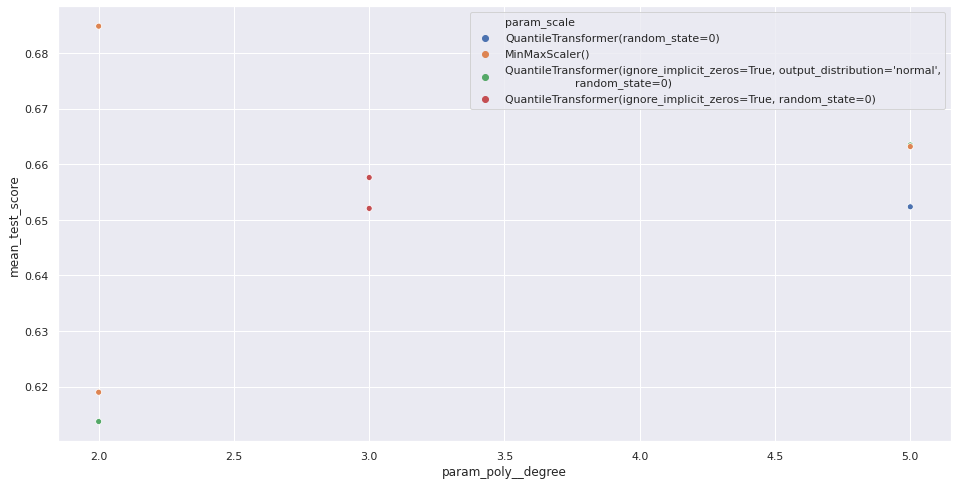

In [188]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(
    data=ada_cv_results,
    x='param_poly__degree',
    y='mean_test_score',
    hue='param_scale',
    ax=ax
)

# Test

In [232]:
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import SelectPercentile, chi2, f_classif, mutual_info_classif

from functools import partial

In [235]:
class SelectPercentileMI(SelectPercentile):
    def __init__(self, percentile=10, n_neighbors=3):
        self.n_neighbors=n_neighbors
        super().__init__(percentile=percentile,
                         score_func=partial(mutual_info_classif, n_neighbors=3))

In [246]:
pipe = Pipeline(steps=[
    ('scale', RobustScaler()),
    ('var0', VarianceThreshold()),
    ('poly', PolynomialFeatures()),
    ('var1', VarianceThreshold()),
    ('select', 'passthrough')
])

params0 = {
    'scale__with_centering' : [True, False],
    'scale__with_scaling' : [True, False],
    'var0__threshold' : stats.uniform(0,0.5),
    'poly__degree' : stats.randint(2, 5),
    'poly__interaction_only' : [True, False],
    'poly__include_bias' : [True, False],
    'var1__threshold' : stats.uniform(0, 0.5),
}

params = [
    {
        **params0,
        'select' : [SelectPercentile()],
        'select__score_func' : [chi2, f_classif],
        'select__percentile' : stats.randint(1,100),
    },
    {
        **params0,
        'select' : [SelectPercentileMI()],
        'select__percentile' : stats.randint(1,100),
        'select__n_neighbors' : stats.randint(2,50),
    },
]

In [ ]:
from sklearn.ensemble import 

# Stuff

In [109]:
train['bl_q'] = np.where(
    train.bone_length < train.bone_length.quantile(0.25),
    0,
    np.where(
        train.bone_length > train.bone_length.quantile(0.75),
        2, 1
    )
)

In [110]:
train['rf_q'] = np.where(
    train.rotting_flesh < train.rotting_flesh.quantile(0.25),
    0,
    np.where(
        train.rotting_flesh > train.rotting_flesh.quantile(0.75),
        2, 1
    )
)

In [111]:
train['hl_q'] = np.where(
    train.hair_length < train.hair_length.quantile(0.25),
    0,
    np.where(
        train.hair_length > train.hair_length.quantile(0.75),
        2, 1
    )
)

In [112]:
train['hs_q'] = np.where(
    train.has_soul < train.has_soul.quantile(0.25),
    0,
    np.where(
        train.has_soul > train.has_soul.quantile(0.75),
        2, 1
    )
)

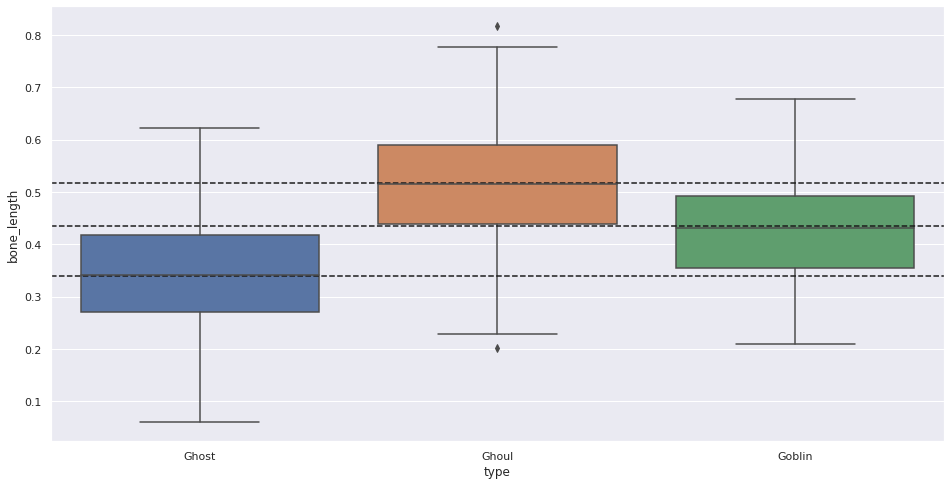

In [144]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(
    data=train,
    x='type',
    y='bone_length',
    ax=ax,
    order=train.type.sort_values().unique()
)

ax.axhline(train.bone_length.quantile(0.25), c='k', ls='--')
ax.axhline(train.bone_length.quantile(0.50), c='k', ls='--')
ax.axhline(train.bone_length.quantile(0.75), c='k', ls='--');

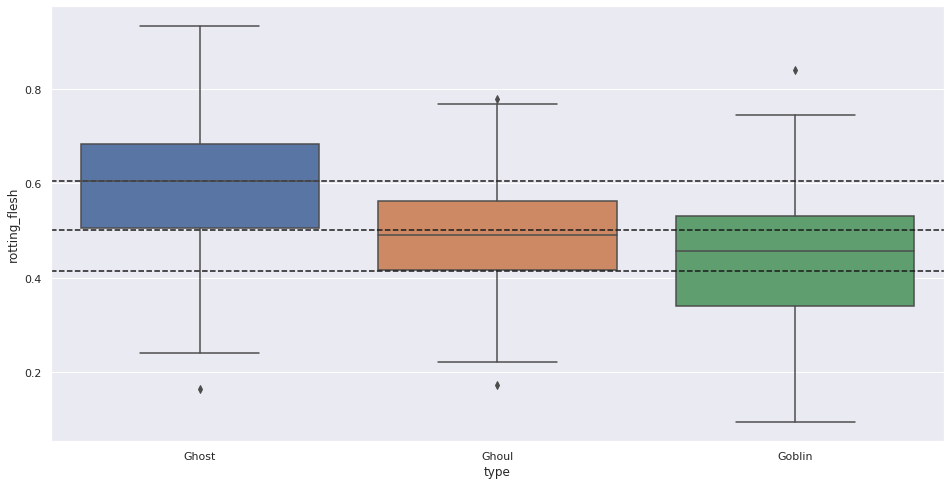

In [143]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(
    data=train,
    x='type',
    y='rotting_flesh',
    ax=ax,
    order=train.type.sort_values().unique()
)

ax.axhline(train.rotting_flesh.quantile(0.25), c='k', ls='--')
ax.axhline(train.rotting_flesh.quantile(0.50), c='k', ls='--')
ax.axhline(train.rotting_flesh.quantile(0.75), c='k', ls='--');

In [138]:
train.groupby([
    'type',
    'hl_q',
]).id.nunique().unstack().apply(lambda x : x/x.sum(), axis=1)

hl_q,0,1,2
type,,,
Ghost,0.598291,0.401709,NaN
Ghoul,0.031008,0.418605,0.550388
Goblin,0.152000,0.672000,0.176000


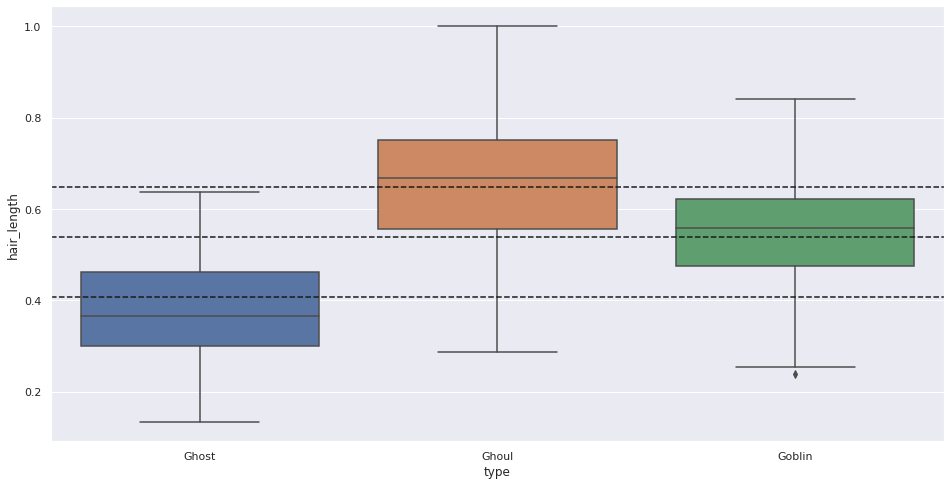

In [141]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(
    data=train,
    x='type',
    y='hair_length',
    ax=ax,
    order=train.type.sort_values().unique()
)

ax.axhline(train.hair_length.quantile(0.25), c='k', ls='--')
ax.axhline(train.hair_length.quantile(0.50), c='k', ls='--')
ax.axhline(train.hair_length.quantile(0.75), c='k', ls='--');

In [139]:
train.groupby([
    'type',
    'hs_q',
]).id.nunique().unstack().apply(lambda x : x/x.sum(), axis=1)

hs_q,0,1,2
type,,,
Ghost,0.589744,0.384615,0.025641
Ghoul,0.023256,0.480620,0.496124
Goblin,0.168000,0.624000,0.208000


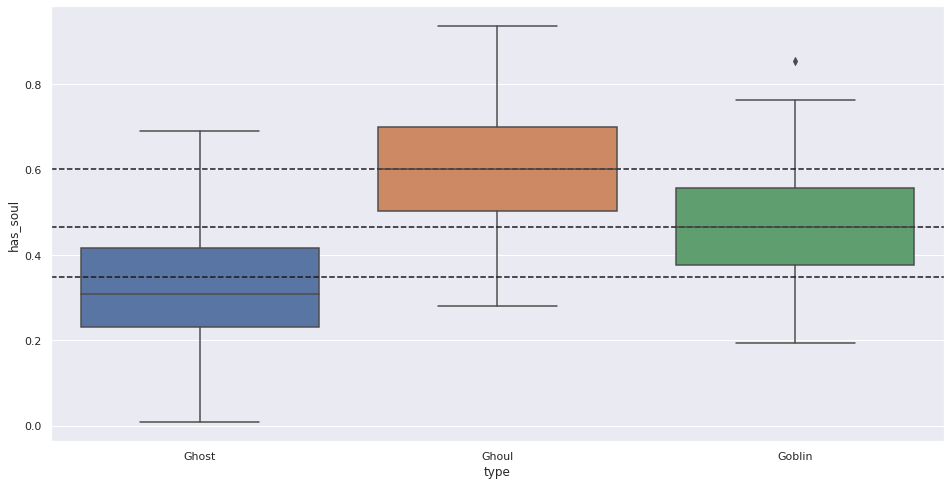

In [140]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(
    data=train,
    x='type',
    y='has_soul',
    ax=ax,
    order=train.type.sort_values().unique()
)

ax.axhline(train.has_soul.quantile(0.25), c='k', ls='--')
ax.axhline(train.has_soul.quantile(0.50), c='k', ls='--')
ax.axhline(train.has_soul.quantile(0.75), c='k', ls='--');

In [78]:
t = train.reindex(columns=[
    'bone_length',
    'rotting_flesh',
    'hair_length',
    'has_soul',
    'type',
])

In [79]:
# t = t.melt(id_vars='type')

In [76]:
t['_neg_prod'] = pd.DataFrame(
    data=MinMaxScaler((-1,1)).fit_transform(t.drop(columns=['type'])),
    columns=t.drop(columns=['type']).columns
).prod(axis=1)

In [80]:
t['_prod'] = t.drop(columns=[
    'type'
]).prod(axis=1)

type
Ghost     AxesSubplot(0.125,0.125;0.775x0.755)
Ghoul     AxesSubplot(0.125,0.125;0.775x0.755)
Goblin    AxesSubplot(0.125,0.125;0.775x0.755)
Name: _prod, dtype: object

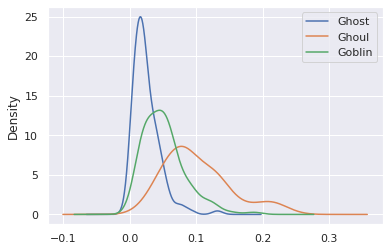

In [83]:
t.groupby(['type'])._prod.plot.kde(legend=True)

In [18]:
ghoul = t.loc[
    t.type == 'Ghoul'
].copy()

/home/ian/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


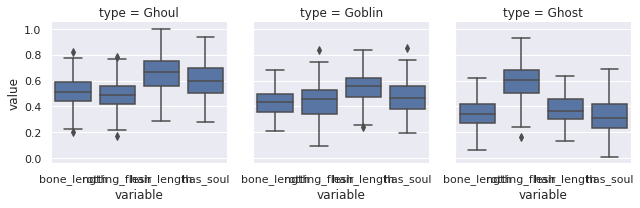

In [50]:
g = sns.FacetGrid(
    data=t,
    col='type',
s)

g.map(sns.boxplot, 'variable', 'value')

(0, 1.1)

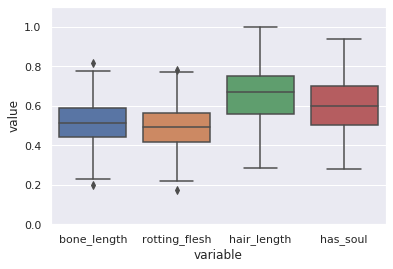

In [35]:
sns.boxplot(
    data=ghoul.drop(columns='type').melt(),
    x='variable',
    y='value'
)

plt.ylim(0, 1.1)

In [19]:
ghost = t.loc[
    t.type == 'Ghost'
].copy()

(0, 1.1)

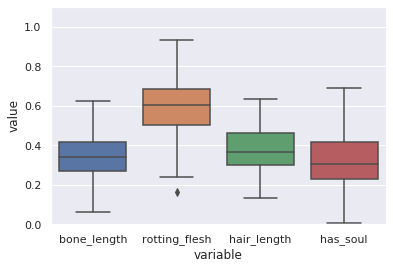

In [36]:
sns.boxplot(
    data=ghost.drop(columns='type').melt(),
    x='variable',
    y='value'
)

plt.ylim(0, 1.1)

In [20]:
goblin = t.loc[
    t.type == 'Goblin'
].copy()

(0, 1.1)

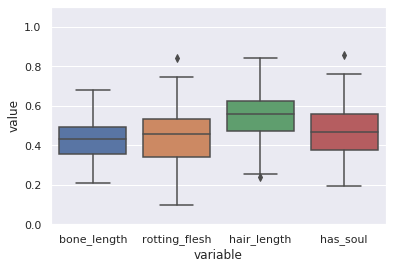

In [37]:
sns.boxplot(
    data=goblin.drop(columns='type').melt(),
    x='variable',
    y='value'
)

plt.ylim(0, 1.1)

In [335]:
train.groupby('type').bone_length.median()

type
Ghost     0.340442
Ghoul     0.515397
Goblin    0.430797
Name: bone_length, dtype: float64

In [336]:
train.groupby('type').bone_length.mean()

type
Ghost     0.347466
Ghoul     0.517159
Goblin    0.429650
Name: bone_length, dtype: float64

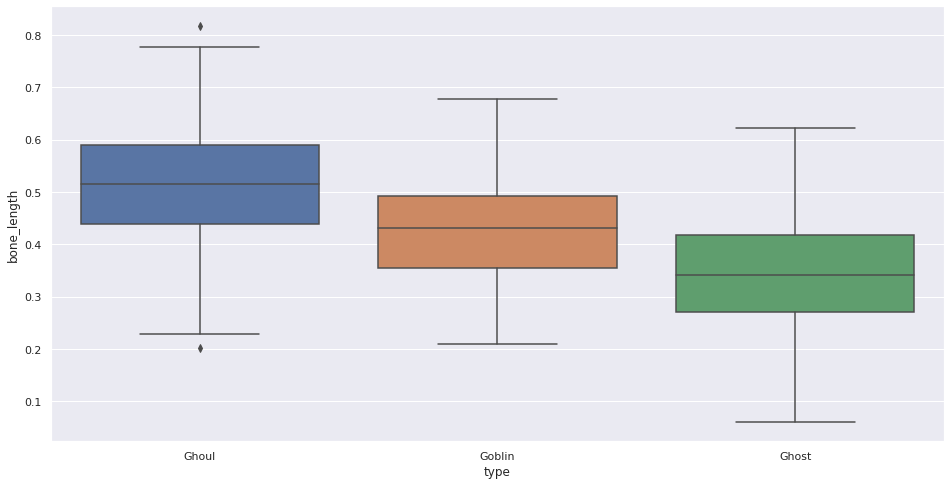

In [334]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(
    data=train,
    y='bone_length',
    x='type',
    ax=ax,
)

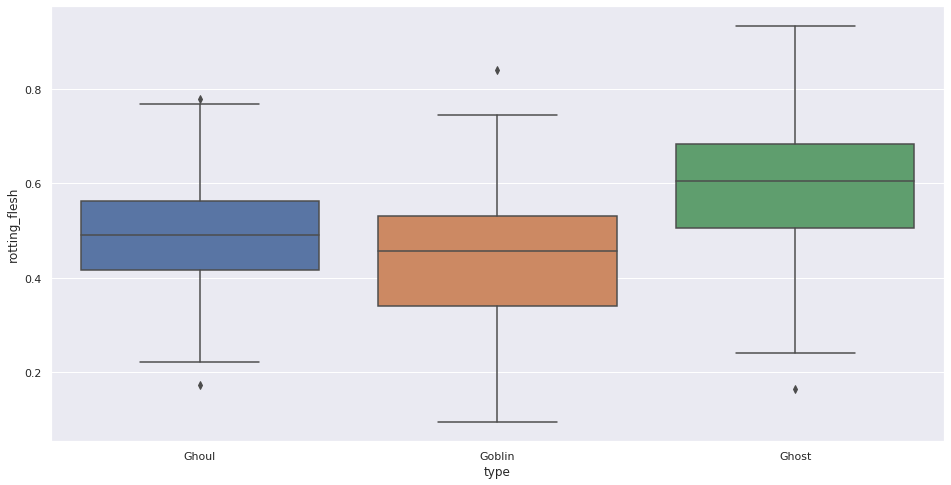

In [338]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(
    data=train,
    y='rotting_flesh',
    x='type',
    ax=ax,
)

In [342]:
train['feature_sum'] = train.reindex(columns=[
    'bone_length',
    'rotting_flesh',
    'hair_length',
    'has_soul',
]).sum(axis=1)

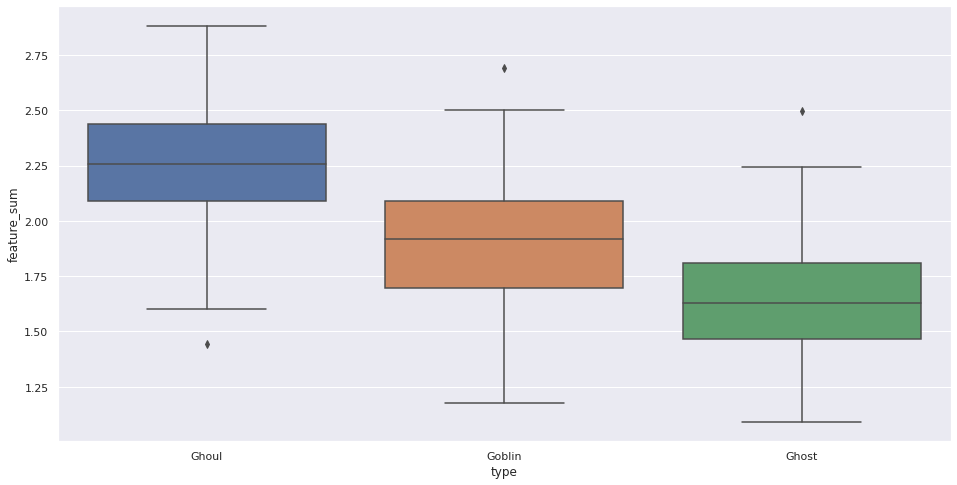

In [344]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(
    data=train,
    y='feature_sum',
    x='type',
    ax=ax,
)

In [337]:
train.columns

Index(['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul',
       'color', 'type'],
      dtype='object')

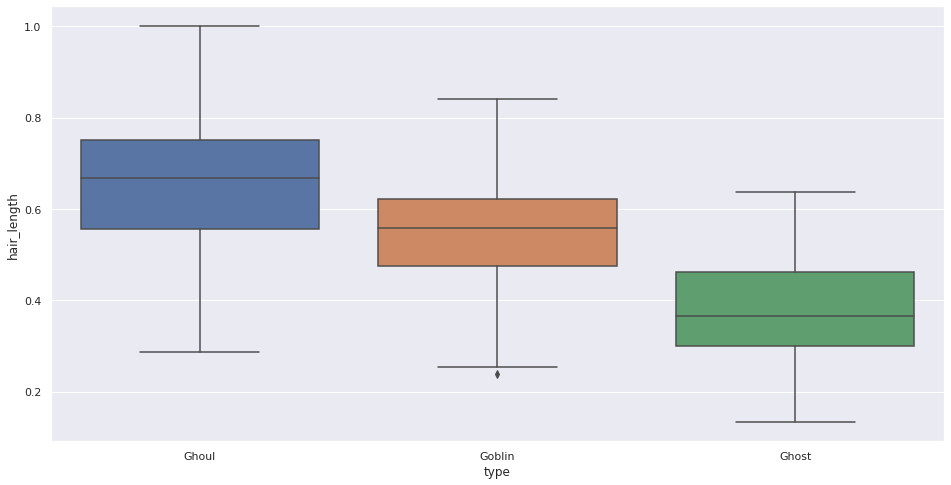

In [339]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(
    data=train,
    y='hair_length',
    x='type',
    ax=ax,
)

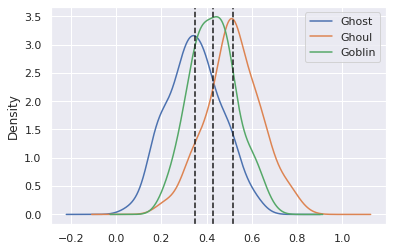

In [324]:
train.groupby([
    'type',
]).bone_length.plot.kde(legend=True)

for i in train.groupby('type').bone_length.mean():
    plt.axvline(i, c='k', ls='--');

In [329]:
train.columns

Index(['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul',
       'color', 'type'],
      dtype='object')

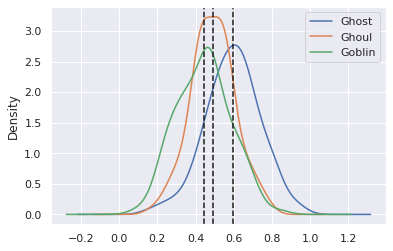

In [330]:
train.groupby([
    'type',
]).rotting_flesh.plot.kde(legend=True)

for i in train.groupby('type').rotting_flesh.mean():
    plt.axvline(i, c='k', ls='--');

In [327]:
stats.normaltest(train.loc[
    train.type == 'Ghost',
    'bone_length'
])

NormaltestResult(statistic=1.438324568785459, pvalue=0.4871601867628075)

In [316]:
train.drop(columns=[
    'id'
]).select_dtypes(exclude=['O']).corr()

,bone_length,rotting_flesh,hair_length,has_soul
bone_length,1.000000,-0.041716,0.353881,0.381675
rotting_flesh,-0.041716,1.000000,-0.220353,-0.132051
hair_length,0.353881,-0.220353,1.000000,0.474835
has_soul,0.381675,-0.132051,0.474835,1.000000


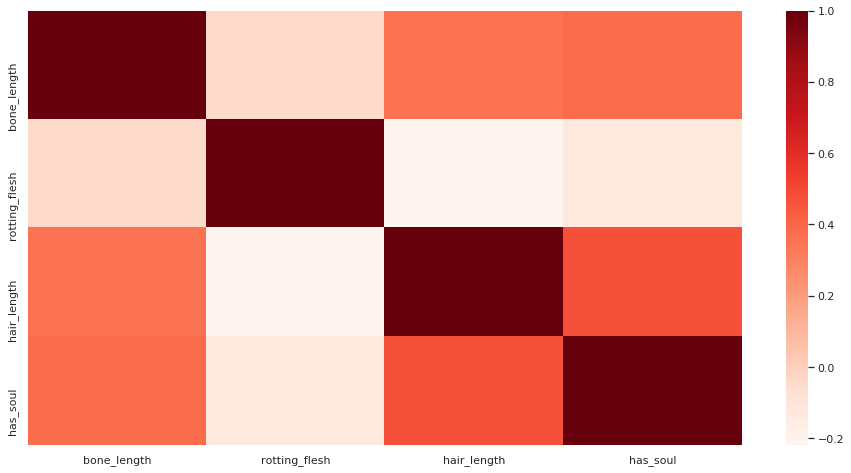

In [320]:
fig, ax = plt.subplots(figsize=(16,8))

sns.heatmap(
    data=train.drop(columns=[
        'id'
    ]).select_dtypes(exclude=['O']).corr(),
    cmap='Reds',
    ax=ax,
)

In [245]:
ohe_color = OneHotEncoder(drop='first', sparse=False)

In [246]:
train = train.join(pd.DataFrame(
    data=ohe_color.fit_transform(train.color.values.reshape(-1,1)),
    columns=ohe_color.get_feature_names()
))

In [248]:
# # get dummy color features
# train = train.join(pd.get_dummies(train.color))

In [249]:
# # create empty list to hold combinations of colors
# c = []

# # create combinations of color features (min 2, max nunique colors - 1)
# for i in range(2, train.color.nunique()):
#     els = [list(x) for x in combinations(train.color.unique(), i)]
#     c.extend(els)

# # sum the combinations and add new column to train
# for i in c:
#     train['_'.join(i)] = train[i].sum(axis=1)

# EDA

## `train_test_split`

In [294]:
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

y = train.type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

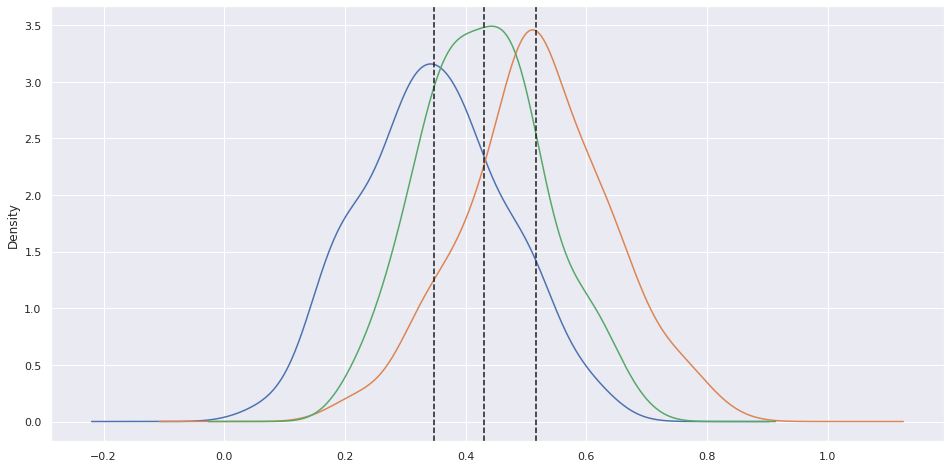

In [303]:
fig, ax = plt.subplots(figsize=(16,8))

train.groupby([
    'type',
]).bone_length.plot.kde(ax=ax);

for i in train.groupby([
    'type',
]).bone_length.mean().values:
    ax.axvline(i, c='k', ls='--')

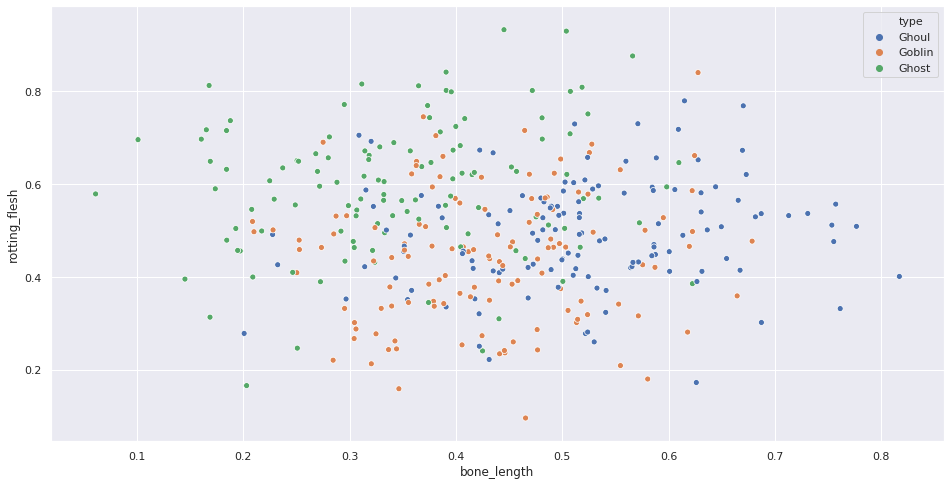

In [297]:
fig, ax = plt.subplots(figsize=(16,8))

sns.kdeplot(
    data=train,
    x='bone_length',
    y='rotting_flesh',
    hue='type',
    ax=ax
)

In [288]:
# X_tsne = TSNE(random_state=0).fit_transform(StandardScaler().fit_transform(X))
X_tsne = TSNE(random_state=0).fit_transform(StandardScaler(with_mean=False).fit_transform(X))
# X_tsne = TSNE(random_state=0).fit_transform(MinMaxScaler().fit_transform(X))
# X_tsne = TSNE(random_state=0).fit_transform(MinMaxScaler(feature_range=(-1,1)).fit_transform(X))
# X_tsne = TSNE(random_state=0).fit_transform(RobustScaler().fit_transform(X))
# X_tsne = TSNE(random_state=0).fit_transform(RobustScaler(with_centering=False).fit_transform(X))

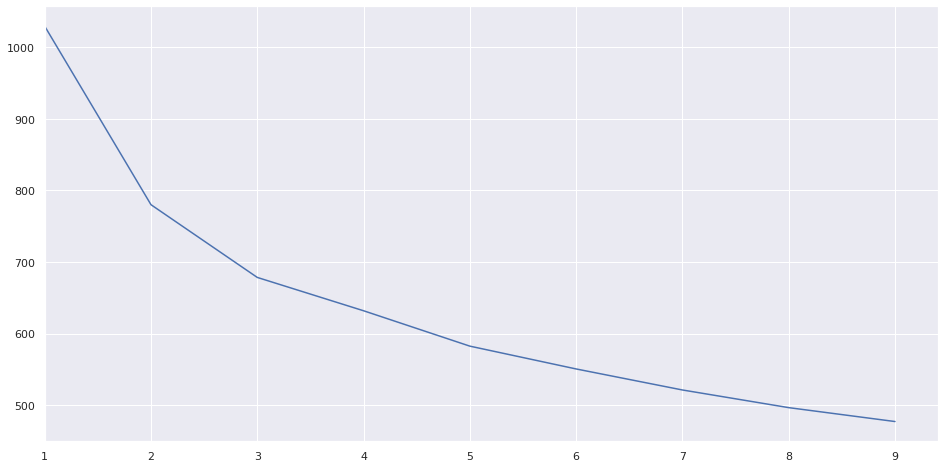

In [289]:
sse = {}

for k in range(1, 10):
    sse[k] = KMeans(n_clusters=k, random_state=0).fit(RobustScaler().fit_transform(X)).inertia_

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(list(sse.keys()), list(sse.values()))

# ax.axvline(6, c='r')

ax.set_xlim(1);

In [290]:
ohe = OneHotEncoder(drop='first', sparse=False)

X = X.join(pd.DataFrame(
#     data=ohe.fit_transform(KMeans(n_clusters=3, random_state=0).fit_predict(X).reshape(-1,1)),
    data=KMeans(n_clusters=2, random_state=0).fit_predict(X),
#     columns=['km_ohe0', 'km_ohe1',]
    columns=['km']
))

In [291]:
# X_tsne = TSNE(random_state=0).fit_transform(StandardScaler().fit_transform(X))
X_tsne = TSNE(random_state=0).fit_transform(StandardScaler(with_mean=False).fit_transform(X))
# X_tsne = TSNE(random_state=0).fit_transform(MinMaxScaler().fit_transform(X))
# X_tsne = TSNE(random_state=0).fit_transform(MinMaxScaler(feature_range=(-1,1)).fit_transform(X))
# X_tsne = TSNE(random_state=0).fit_transform(RobustScaler().fit_transform(X))
# X_tsne = TSNE(random_state=0).fit_transform(RobustScaler(with_centering=False).fit_transform(X))

In [292]:
train.groupby([
    'color',
    'type',
]).id.nunique().unstack().apply(lambda x : x/x.sum(), axis=1).style.background_gradient(axis=0)

type,Ghost,Ghoul,Goblin
color,,,
black,0.341463,0.341463,0.317073
blood,0.500000,0.333333,0.166667
blue,0.315789,0.315789,0.368421
clear,0.266667,0.350000,0.383333
green,0.357143,0.309524,0.333333
white,0.321168,0.364964,0.313869


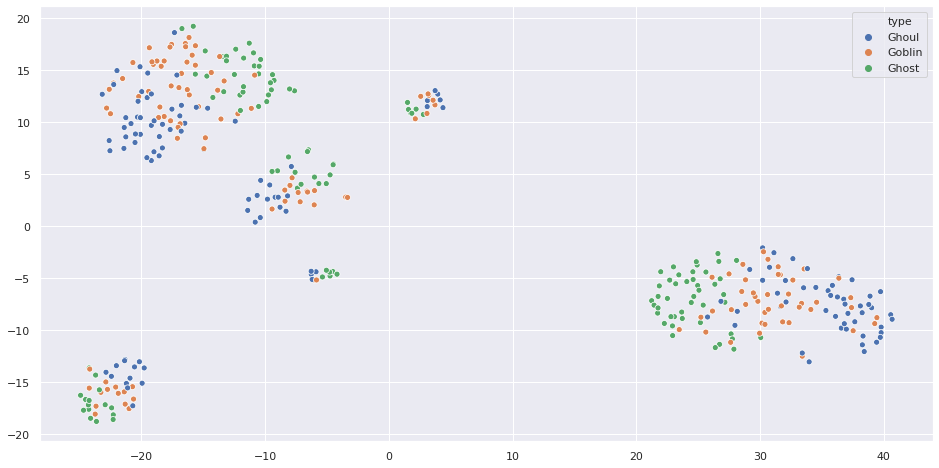

In [293]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y
);

## Pipe

### Cleaner

In [273]:
class ScalerSwap(BaseEstimator):
    
    def __init__(self, scaler = StandardScaler()):
        """
        A Custom BaseEstimator that can switch between scalers.
        :param estimator: sklearn object - The scaler
        """ 
        
        self.scaler = scaler

    def fit(self, X, y=None, **kwargs):
        self.scaler.fit(X, y)
        return self

    def transform(self, X, **kwargs):
        self.scaler.transform(X)
        return self

In [274]:
pipe_cleaner = Pipeline([
    ('poly', PolynomialFeatures()),
#     ('scaler', ScalerSwap()),
    ('scaler', StandardScaler()),
    ('vt', VarianceThreshold()),
])

cleaner_params = {
    'cleaner__poly__degree' : stats.distributions.randint(2, 4+1),
    'cleaner__poly__include_bias' : [True, False],
    'cleaner__poly__interaction_only' : [True, False],
    'cleaner__vt__threshold' : stats.distributions.uniform(0.0, 2e-2),
}

scaler_params = [
    {
#         'cleaner__scaler__scaler' : [StandardScaler()],
#         'cleaner__scaler__scaler__with_mean' : [True, False],
#         'cleaner__scaler__scaler__with_std' : [True, False],
        'cleaner__scaler__with_mean' : [True, False],
        'cleaner__scaler__with_std' : [True, False],
    },
#     {
#         'cleaner__scaler__scaler' : [MinMaxScaler()],
#         'cleaner__scaler__scaler__feature_range' : [(0,1), (-1,1), (-0.5, 0.5)],
#     },
#     {
#         'cleaner__scaler__scaler' : [RobustScaler()],
#         'cleaner__scaler__scaler__with_centering' : [True, False],
#         'cleaner__scaler__scaler__with_scaling' : [True, False],
#     }
]

cleaner_params = {**cleaner_params, **np.random.choice(scaler_params)}

### Decomposition

In [275]:
pipe_decomp = Pipeline([
    ('union', FeatureUnion([
        ('pca', PCA(random_state=0)),
        ('svd', TruncatedSVD(random_state=0))
    ], n_jobs=-1))
])

decomp_params = {
    'decomp__union__pca__n_components' : stats.distributions.uniform(0.5, 0.5),
    'decomp__union__pca__whiten' : [True, False],
#     'decomp__union__pca__svd_solver' : ['auto', 'full', 'arpack', 'randomized'],
    'decomp__union__pca__tol' : stats.distributions.uniform(0.0, 0.5),
    'decomp__union__svd__n_components' : stats.distributions.randint(2, 50),
    'decomp__union__svd__algorithm' : ['randomized', 'arpack'],
    'decomp__union__svd__n_iter' : stats.distributions.randint(5, 15),
    'decomp__union__svd__tol' : stats.distributions.uniform(0.0, 0.5),
}

### Unsupervised Clustering

In [276]:
class ModelTransformer(TransformerMixin, BaseEstimator):
    
    def __init__(self, model):
        self.model = model
    
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    
    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.fit_predict(X))

pipe_cluster = Pipeline([
    ('union', FeatureUnion([
        ('optics', ModelTransformer(OPTICS(n_jobs=-1))),
        ('dbscan', ModelTransformer(DBSCAN(n_jobs=-1))),
        ('kmeans', ModelTransformer(KMeans(random_state=0, n_jobs=-1))),
        ('meanshift', ModelTransformer(MeanShift(n_jobs=-1))),
        ('agglom', ModelTransformer(AgglomerativeClustering())),
        ('affinity', ModelTransformer(AffinityPropagation()))
    ], n_jobs=-1)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

cluster_params = {
    'cluster__union__optics__model__min_samples' : stats.distributions.randint(2, 11),
    'cluster__union__optics__model__max_eps' : stats.distributions.uniform(1e-3, 3),
    'cluster__union__optics__model__p' : stats.distributions.randint(1,3),
    'cluster__union__optics__model__cluster_method' : ['xi', 'dbscan'],
    'cluster__union__optics__model__eps' : stats.distributions.uniform(1e-3, 3),
    'cluster__union__optics__model__xi' : stats.distributions.uniform(0, 1),
    'cluster__union__optics__model__predecessor_correction' : [True, False],
    'cluster__union__optics__model__min_cluster_size' : [None] + list(range(2, 11)),
    'cluster__union__optics__model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'cluster__union__optics__model__leaf_size' : stats.distributions.randint(20, 41),
    'cluster__union__dbscan__model__eps' : stats.distributions.uniform(1e-3, 3),
    'cluster__union__dbscan__model__min_samples' : stats.distributions.randint(2, 11),
    'cluster__union__dbscan__model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'cluster__union__dbscan__model__leaf_size' : stats.distributions.randint(20, 41),
    'cluster__union__dbscan__model__p' : [None] + list(np.random.uniform(1e-3, 5, size=20)),
    'cluster__union__kmeans__model__n_clusters' : stats.distributions.randint(2, 12),
    'cluster__union__kmeans__model__n_init' : stats.distributions.randint(10, 101),
    'cluster__union__kmeans__model__max_iter' : stats.distributions.randint(300, 501),
    'cluster__union__kmeans__model__tol' : stats.distributions.uniform(1e-6, 1e-1),
    'cluster__union__kmeans__model__algorithm' : ['auto', 'full', 'elkan'],
    'cluster__union__meanshift__model__bandwidth' : [None] + list(np.random.uniform(1e-3, 5, size=20)),
    'cluster__union__meanshift__model__cluster_all' : [True, False],
    'cluster__union__meanshift__model__max_iter' : stats.distributions.randint(300, 501),
    'cluster__union__agglom__model__affinity' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
    'cluster__union__agglom__model__compute_full_tree' : ['auto', True, False],
    'cluster__union__agglom__model__linkage' : ['ward', 'complete', 'average', 'single'],
    'cluster__union__affinity__model__damping' : stats.distributions.uniform(0.5, 0.5),
    'cluster__union__affinity__model__max_iter' : stats.distributions.randint(200, 401),
    'cluster__union__affinity__model__convergence_iter' : stats.distributions.randint(10, 31),
    'cluster__ohe__sparse' : [False],
}

### Classifier Swapping

In [277]:
class ClfSwap(BaseEstimator):
    
    def __init__(self, estimator = SGDClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 
        
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [278]:
pre_params = {**cleaner_params, **decomp_params, **cluster_params}

pipe_clf = Pipeline([
    ('cleaner', pipe_cleaner),
    ('decomp', pipe_decomp),
    ('cluster', pipe_cluster),
    ('clf', OneVsRestClassifier(ClfSwap(), n_jobs=-1)),
])

clf_params = [
    {
        'clf__estimator__estimator' : [AdaBoostClassifier(random_state=0)],
        **pre_params,
        'clf__estimator__estimator__n_estimators' : stats.distributions.randint(50, 200),
        'clf__estimator__estimator__learning_rate' : stats.distributions.uniform(0.5, 1),
        'clf__estimator__estimator__algorithm' : ['SAMME', 'SAMME.R'],
    },
    {
        'clf__estimator__estimator' : [GradientBoostingClassifier(random_state=0)],
        **pre_params,
        'clf__estimator__estimator__loss' : ['deviance', 'exponential'],
        'clf__estimator__estimator__learning_rate' : stats.distributions.uniform(0.5, 1),
        'clf__estimator__estimator__n_estimators' : stats.distributions.randint(100, 400),
        'clf__estimator__estimator__criterion' : ['friedman_mse', 'mse', 'mae'],
        'clf__estimator__estimator__max_features' : ['sqrt', 'log2', None]
    },
    {
        'clf__estimator__estimator' : [ExtraTreesClassifier(random_state=0, n_jobs=-1)],
        **pre_params,
        'clf__estimator__estimator__n_estimators' : stats.distributions.randint(100, 400),
        'clf__estimator__estimator__criterion' : ['gini', 'entropy'],
        'clf__estimator__estimator__max_features' : ['sqrt', 'log2', None],
    },
    {
        'clf__estimator__estimator' : [RandomForestClassifier(random_state=0, n_jobs=-1)],
        **pre_params,
        'clf__estimator__estimator__n_estimators' : stats.distributions.randint(100, 400),
        'clf__estimator__estimator__criterion' : ['gini', 'entropy'],
        'clf__estimator__estimator__max_features' : ['sqrt', 'log2', None]
    },
    {
        'clf__estimator__estimator' : [LogisticRegression(penalty='elasticnet', solver='saga', random_state=0, n_jobs=-1)],
        **pre_params,
        'clf__estimator__estimator__tol' : stats.distributions.uniform(1e-6, 1e-1),
        'clf__estimator__estimator__C' : stats.distributions.uniform(0.5, 1),
        'clf__estimator__estimator__fit_intercept' : [True, False],
        'clf__estimator__estimator__max_iter' : stats.distributions.randint(100, 400),
        'clf__estimator__estimator__l1_ratio' : stats.distributions.uniform(0, 1),
    },
    {
        'clf__estimator__estimator' : [LogisticRegression(penalty='l2', random_state=0, n_jobs=-1)],
        **pre_params,
        'clf__estimator__estimator__tol' : stats.distributions.uniform(1e-6, 1e-1),
        'clf__estimator__estimator__C' : stats.distributions.uniform(0.5, 1),
        'clf__estimator__estimator__fit_intercept' : [True, False],
        'clf__estimator__estimator__solver' : ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'],
        'clf__estimator__estimator__max_iter' : stats.distributions.randint(100, 400),
        'clf__estimator__estimator__l1_ratio' : stats.distributions.uniform(0, 1),
    },
    {
        'clf__estimator__estimator' : [LogisticRegression(penalty='l1', random_state=0, n_jobs=-1)],
        **pre_params,
        'clf__estimator__estimator__tol' : stats.distributions.uniform(1e-6, 1e-1),
        'clf__estimator__estimator__C' : stats.distributions.uniform(0.5, 1),
        'clf__estimator__estimator__fit_intercept' : [True, False],
        'clf__estimator__estimator__solver' : ['saga', 'liblinear'],
        'clf__estimator__estimator__max_iter' : stats.distributions.randint(100, 400),
        'clf__estimator__estimator__l1_ratio' : stats.distributions.uniform(0, 1),
    },
    {
        'clf__estimator__estimator' : [LogisticRegression(penalty='none', random_state=0, n_jobs=-1)],
        **pre_params,
        'clf__estimator__estimator__tol' : stats.distributions.uniform(1e-6, 1e-1),
        'clf__estimator__estimator__C' : stats.distributions.uniform(0.5, 1),
        'clf__estimator__estimator__fit_intercept' : [True, False],
        'clf__estimator__estimator__solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'clf__estimator__estimator__max_iter' : stats.distributions.randint(100, 400),
        'clf__estimator__estimator__l1_ratio' : stats.distributions.uniform(0, 1),
    },
    {
        'clf__estimator__estimator' : [MultinomialNB()],
        **pre_params,
        'clf__estimator__estimator__alpha' : stats.distributions.uniform(1e-7, 3),
        'clf__estimator__estimator__fit_prior' : [True, False],
    },
    {
        'clf__estimator__estimator' : [GaussianProcessClassifier(random_state=0)],
        **pre_params
    },
    {
        'clf__estimator__estimator' : [KNeighborsClassifier()],
        **pre_params
    },
    {
        'clf__estimator__estimator' : [MLPClassifier(random_state=0)],
        **pre_params
    },
    {
        'clf__estimator__estimator' : [LinearSVC(random_state=0)],
        **pre_params
    },
    {
        'clf__estimator__estimator' : [SVC(random_state=0)],
        **pre_params
    },
    {
        'clf__estimator__estimator' : [SGDClassifier(random_state=0)],
        **pre_params
    },
]

### RandomSearchCV

In [279]:
rcv = RandomizedSearchCV(
    estimator=pipe_clf,
    param_distributions=clf_params,
    n_iter=10,
    n_jobs=-1,
    cv=10,
    random_state=0,
    verbose=5,
)

In [280]:
rcv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('cleaner',
                                              Pipeline(memory=None,
                                                       steps=[('poly',
                                                               PolynomialFeatures(degree=2,
                                                                                  include_bias=True,
                                                                                  interaction_only=False,
                                                                                  order='C')),
                                                              ('scaler',
                                                               StandardScaler(copy=True,
                                                                              with_mean=True,
                                                            

In [281]:
rcv.best_score_

0.4092307692307693

In [ ]:
# pipe = Pipeline([
#     ('cleaner', pipe_cleaner),
#     ('decomp', pipe_decomp),
#     ('cluster', pipe_cluster),
#     ('clf', pipe_clf),
# ], verbose=True)

In [ ]:
# pipe.set_params(**params)

# _ = pipe.fit_transform(X)

In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.scatterplot(
#     data=pd.DataFrame(_).join(train.type),
#     x=0,
#     y=1,
#     hue='type',
#     ax=ax,
#     s=100
# );

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(
    data=pd.DataFrame(_).join(train.type),
    x=0,
    y=1,
    hue='type',
    ax=ax,
    s=100
);

## `bone_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_bone_length = train.groupby([
    'type',
]).bone_length.min().sort_values()

lower_bone_length

In [ ]:
train['bone_length_lower'] = train.bone_length < lower_bone_length.iloc[1]

In [ ]:
upper_bone_length = train.groupby([
    'type',
]).bone_length.max().sort_values()

upper_bone_length

In [ ]:
train['bone_length_upper'] = train.bone_length > upper_bone_length.iloc[1]

## `rotting_flesh`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='rotting_flesh',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='rotting_flesh',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'rotting_flesh'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_rotting_flesh = train.groupby([
    'type',
]).rotting_flesh.min().sort_values()

lower_rotting_flesh

In [ ]:
train['rotting_flesh_lower'] = train.rotting_flesh < lower_rotting_flesh.iloc[1]

In [ ]:
upper_rotting_flesh = train.groupby([
    'type',
]).rotting_flesh.max().sort_values()

upper_rotting_flesh

In [ ]:
train['rotting_flesh_upper'] = train.rotting_flesh > upper_rotting_flesh.iloc[1]

## `hair_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='hair_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='hair_length',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'hair_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_hair_length = train.groupby([
    'type',
]).hair_length.min().sort_values()

lower_hair_length

In [ ]:
train['hair_length_lower'] = train.hair_length < lower_hair_length.iloc[1]

In [ ]:
upper_hair_length = train.groupby([
    'type',
]).hair_length.max().sort_values()

upper_hair_length

In [ ]:
train['hair_length_upper'] = train.hair_length > upper_hair_length.iloc[1]

## `has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='has_soul',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_has_soul = train.groupby([
    'type',
]).has_soul.min().sort_values()

lower_has_soul

In [ ]:
train['has_soul_lower'] = train.has_soul < lower_has_soul.iloc[1]

In [ ]:
upper_has_soul = train.groupby([
    'type',
]).has_soul.max().sort_values()

upper_has_soul

In [ ]:
train['has_soul_upper'] = train.has_soul > upper_has_soul.iloc[1]

## Color Counts

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.heatmap(
    data=train.groupby([
        'type',
        'color',
    ]).id.nunique().unstack().apply(lambda x : x / x.sum(), axis=1).round(4)*100,
    ax=ax,
    annot=True,
    annot_kws={
        'fontsize' : 12,
    },
    cmap='Reds',
    fmt='g',
);

### `bone_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_bone_length = train.groupby([
    'color',
    'type',
]).bone_length.min()

lower_color_bone_length

In [ ]:
for color in lower_color_bone_length.index.levels[0]:
    lcbl = lower_color_bone_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_lower'] = (train.color == color) & (train.bone_length < lcbl)

In [ ]:
upper_color_bone_length = train.groupby([
    'color',
    'type',
]).bone_length.max()

upper_color_bone_length

In [ ]:
for color in upper_color_bone_length.index.levels[0]:
    ucbl = upper_color_bone_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_upper'] = (train.color == color) & (train.bone_length > ucbl)

### `rotting_flesh`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='rotting_flesh',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='rotting_flesh',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_rotting_flesh = train.groupby([
    'color',
    'type',
]).rotting_flesh.min()

lower_color_rotting_flesh

In [ ]:
for color in lower_color_rotting_flesh.index.levels[0]:
    lcbl = lower_color_rotting_flesh.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_lower'] = (train.color == color) & (train.rotting_flesh < lcbl)

In [ ]:
upper_color_rotting_flesh = train.groupby([
    'color',
    'type',
]).rotting_flesh.max()

upper_color_rotting_flesh

In [ ]:
for color in upper_color_rotting_flesh.index.levels[0]:
    ucbl = upper_color_rotting_flesh.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_upper'] = (train.color == color) & (train.rotting_flesh > ucbl)

### `hair_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='hair_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='hair_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_hair_length = train.groupby([
    'color',
    'type',
]).hair_length.min()

lower_color_hair_length

In [ ]:
for color in lower_color_hair_length.index.levels[0]:
    lcbl = lower_color_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_hair_length_lower'] = (train.color == color) & (train.hair_length < lcbl)

In [ ]:
upper_color_hair_length = train.groupby([
    'color',
    'type',
]).hair_length.max()

upper_color_hair_length

In [ ]:
for color in upper_color_hair_length.index.levels[0]:
    ucbl = upper_color_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_hair_length_upper'] = (train.color == color) & (train.hair_length > ucbl)

### `has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_has_soul = train.groupby([
    'color',
    'type',
]).has_soul.min()

lower_color_has_soul

In [ ]:
for color in lower_color_has_soul.index.levels[0]:
    lcbl = lower_color_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_has_soul_lower'] = (train.color == color) & (train.has_soul < lcbl)

In [ ]:
upper_color_has_soul = train.groupby([
    'color',
    'type',
]).has_soul.max()

upper_color_has_soul

In [ ]:
for color in upper_color_has_soul.index.levels[0]:
    ucbl = upper_color_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_has_soul_upper'] = (train.color == color) & (train.has_soul > ucbl)

## Continuous Interactions

### 2-way

In [ ]:
train['bone_length_rotting_flesh'] = train.bone_length * train.rotting_flesh

train['bone_length_hair_length'] = train.bone_length * train.hair_length

train['bone_length_has_soul'] = train.bone_length * train.has_soul

train['rotting_flesh_hair_length'] = train.rotting_flesh * train.hair_length

train['rotting_flesh_has_soul'] = train.rotting_flesh * train.has_soul

train['hair_length_has_soul'] = train.hair_length * train.has_soul

#### `bone_length_rotting_flesh`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_rotting_flesh'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_bone_length_rotting_flesh = train.groupby([
    'type',
]).bone_length_rotting_flesh.min().sort_values()

lower_bone_length_rotting_flesh

In [ ]:
train['bone_length_rotting_flesh_lower'] = train.bone_length_rotting_flesh < lower_bone_length_rotting_flesh.iloc[1]

In [ ]:
upper_bone_length_rotting_flesh = train.groupby([
    'type',
]).bone_length_rotting_flesh.max().sort_values()

upper_bone_length_rotting_flesh

In [ ]:
train['bone_length_rotting_flesh_upper'] = train.bone_length_rotting_flesh > upper_bone_length_rotting_flesh.iloc[1]

#### `bone_length_hair_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_hair_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_hair_length',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_hair_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_bone_length_hair_length = train.groupby([
    'type',
]).bone_length_hair_length.min().sort_values()

lower_bone_length_hair_length

In [ ]:
train['bone_length_hair_length_lower'] = train.bone_length_hair_length < lower_bone_length_hair_length.iloc[1]

In [ ]:
upper_bone_length_hair_length = train.groupby([
    'type',
]).bone_length_hair_length.max().sort_values()

upper_bone_length_hair_length

In [ ]:
train['bone_length_hair_length_upper'] = train.bone_length_hair_length > upper_bone_length_hair_length.iloc[1]

#### `bone_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_has_soul',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_bone_length_has_soul = train.groupby([
    'type',
]).bone_length_has_soul.min().sort_values()

lower_bone_length_has_soul

In [ ]:
train['bone_length_has_soul_lower'] = train.bone_length_has_soul < lower_bone_length_has_soul.iloc[1]

In [ ]:
upper_bone_length_has_soul = train.groupby([
    'type',
]).bone_length_has_soul.max().sort_values()

upper_bone_length_has_soul

In [ ]:
train['bone_length_has_soul_upper'] = train.bone_length_has_soul > upper_bone_length_has_soul.iloc[1]

#### `rotting_flesh_hair_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='rotting_flesh_hair_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='rotting_flesh_hair_length',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'rotting_flesh_hair_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_rotting_flesh_hair_length = train.groupby([
    'type',
]).rotting_flesh_hair_length.min().sort_values()

lower_rotting_flesh_hair_length

In [ ]:
train['rotting_flesh_hair_length_lower'] = train.rotting_flesh_hair_length < lower_rotting_flesh_hair_length.iloc[1]

In [ ]:
upper_rotting_flesh_hair_length = train.groupby([
    'type',
]).rotting_flesh_hair_length.max().sort_values()

upper_rotting_flesh_hair_length

In [ ]:
train['rotting_flesh_hair_length_upper'] = train.rotting_flesh_hair_length > upper_rotting_flesh_hair_length.iloc[1]

#### `rotting_flesh_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='rotting_flesh_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='rotting_flesh_has_soul',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'rotting_flesh_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_rotting_flesh_has_soul = train.groupby([
    'type',
]).rotting_flesh_has_soul.min().sort_values()

lower_rotting_flesh_has_soul

In [ ]:
train['rotting_flesh_has_soul_lower'] = train.rotting_flesh_has_soul < lower_rotting_flesh_has_soul.iloc[1]

In [ ]:
upper_rotting_flesh_has_soul = train.groupby([
    'type',
]).rotting_flesh_has_soul.max().sort_values()

upper_rotting_flesh_has_soul

In [ ]:
train['rotting_flesh_has_soul_upper'] = train.rotting_flesh_has_soul > upper_rotting_flesh_has_soul.iloc[1]

#### `hair_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='hair_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='hair_length_has_soul',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'hair_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_hair_length_has_soul = train.groupby([
    'type',
]).hair_length_has_soul.min().sort_values()

lower_hair_length_has_soul

In [ ]:
train['hair_length_has_soul_lower'] = train.hair_length_has_soul < lower_hair_length_has_soul.iloc[1]

In [ ]:
upper_hair_length_has_soul = train.groupby([
    'type',
]).hair_length_has_soul.max().sort_values()

upper_hair_length_has_soul

In [ ]:
train['hair_length_has_soul_upper'] = train.hair_length_has_soul > upper_hair_length_has_soul.iloc[1]

### 3-way

In [ ]:
train['bone_length_rotting_flesh_hair_length'] = train.bone_length_rotting_flesh * train.hair_length

train['bone_length_rotting_flesh_has_soul'] = train.bone_length_rotting_flesh * train.has_soul

train['bone_length_hair_length_has_soul'] = train.bone_length_hair_length * train.has_soul

train['rotting_flesh_hair_length_has_soul'] = train.rotting_flesh_hair_length * train.has_soul

#### `bone_length_rotting_flesh_hair_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_hair_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_hair_length',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_rotting_flesh_hair_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_bone_length_rotting_flesh_hair_length = train.groupby([
    'type',
]).bone_length_rotting_flesh_hair_length.min().sort_values()

lower_bone_length_rotting_flesh_hair_length

In [ ]:
train['bone_length_rotting_flesh_hair_length_lower'] = train.bone_length_rotting_flesh_hair_length < lower_bone_length_rotting_flesh_hair_length.iloc[1]

In [ ]:
upper_bone_length_rotting_flesh_hair_length = train.groupby([
    'type',
]).bone_length_rotting_flesh_hair_length.max().sort_values()

upper_bone_length_rotting_flesh_hair_length

In [ ]:
train['bone_length_rotting_flesh_hair_length_upper'] = train.bone_length_rotting_flesh_hair_length > upper_bone_length_rotting_flesh_hair_length.iloc[1]

#### `bone_length_rotting_flesh_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_has_soul',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_rotting_flesh_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_bone_length_rotting_flesh_has_soul = train.groupby([
    'type',
]).bone_length_rotting_flesh_has_soul.min().sort_values()

lower_bone_length_rotting_flesh_has_soul

In [ ]:
train['bone_length_rotting_flesh_has_soul_lower'] = train.bone_length_rotting_flesh_has_soul < lower_bone_length_rotting_flesh_has_soul.iloc[1]

In [ ]:
upper_bone_length_rotting_flesh_has_soul = train.groupby([
    'type',
]).bone_length_rotting_flesh_has_soul.max().sort_values()

upper_bone_length_rotting_flesh_has_soul

In [ ]:
train['bone_length_rotting_flesh_has_soul_upper'] = train.bone_length_rotting_flesh_has_soul > upper_bone_length_rotting_flesh_has_soul.iloc[1]

#### `bone_length_hair_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_hair_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_hair_length_has_soul',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_hair_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_bone_length_hair_length_has_soul = train.groupby([
    'type',
]).bone_length_hair_length_has_soul.min().sort_values()

lower_bone_length_hair_length_has_soul

In [ ]:
train['bone_length_hair_length_has_soul_lower'] = train.bone_length_hair_length_has_soul < lower_bone_length_hair_length_has_soul.iloc[1]

In [ ]:
upper_bone_length_hair_length_has_soul = train.groupby([
    'type',
]).bone_length_hair_length_has_soul.max().sort_values()

upper_bone_length_hair_length_has_soul

In [ ]:
train['bone_length_hair_length_has_soul_upper'] = train.bone_length_hair_length_has_soul > upper_bone_length_hair_length_has_soul.iloc[1]

#### `rotting_flesh_hair_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='rotting_flesh_hair_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='rotting_flesh_hair_length_has_soul',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'rotting_flesh_hair_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_rotting_flesh_hair_length_has_soul = train.groupby([
    'type',
]).rotting_flesh_hair_length_has_soul.min().sort_values()

lower_rotting_flesh_hair_length_has_soul

In [ ]:
train['rotting_flesh_hair_length_has_soul_lower'] = train.rotting_flesh_hair_length_has_soul < lower_rotting_flesh_hair_length_has_soul.iloc[1]

In [ ]:
upper_rotting_flesh_hair_length_has_soul = train.groupby([
    'type',
]).rotting_flesh_hair_length_has_soul.max().sort_values()

upper_rotting_flesh_hair_length_has_soul

In [ ]:
train['rotting_flesh_hair_length_has_soul_upper'] = train.rotting_flesh_hair_length_has_soul > upper_rotting_flesh_hair_length_has_soul.iloc[1]

### 4-way

In [ ]:
train['bone_length_rotting_flesh_hair_length_has_soul'] = train.bone_length_rotting_flesh_hair_length * train.has_soul

#### `bone_length_rotting_flesh_hair_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_hair_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_hair_length_has_soul',
);

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_rotting_flesh_hair_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [ ]:
lower_bone_length_rotting_flesh_hair_length_has_soul = train.groupby([
    'type',
]).bone_length_rotting_flesh_hair_length_has_soul.min().sort_values()

lower_bone_length_rotting_flesh_hair_length_has_soul

In [ ]:
train['bone_length_rotting_flesh_hair_length_has_soul_lower'] = train.bone_length_rotting_flesh_hair_length_has_soul < lower_bone_length_rotting_flesh_hair_length_has_soul.iloc[1]

In [ ]:
upper_bone_length_rotting_flesh_hair_length_has_soul = train.groupby([
    'type',
]).bone_length_rotting_flesh_hair_length_has_soul.max().sort_values()

upper_bone_length_rotting_flesh_hair_length_has_soul

In [ ]:
train['bone_length_rotting_flesh_hair_length_has_soul_upper'] = train.bone_length_rotting_flesh_hair_length_has_soul > upper_bone_length_rotting_flesh_hair_length_has_soul.iloc[1]

In [ ]:
train.head()

## Continuous Interactions + Color

### 2-way

#### `bone_length_rotting_flesh`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_bone_length_rotting_flesh = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh.min()

lower_color_bone_length_rotting_flesh

In [ ]:
for color in lower_color_bone_length_rotting_flesh.index.levels[0]:
    lcbl = lower_color_bone_length_rotting_flesh.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_lower'] = (train.color == color) & (train.bone_length_rotting_flesh < lcbl)

In [ ]:
upper_color_bone_length_rotting_flesh = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh.max()

upper_color_bone_length_rotting_flesh

In [ ]:
for color in upper_color_bone_length_rotting_flesh.index.levels[0]:
    ucbl = upper_color_bone_length_rotting_flesh.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_upper'] = (train.color == color) & (train.bone_length_rotting_flesh > ucbl)

#### `bone_length_hair_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_hair_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_hair_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_bone_length_hair_length = train.groupby([
    'color',
    'type',
]).bone_length_hair_length.min()

lower_color_bone_length_hair_length

In [ ]:
for color in lower_color_bone_length_hair_length.index.levels[0]:
    lcbl = lower_color_bone_length_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_hair_length_lower'] = (train.color == color) & (train.bone_length_hair_length < lcbl)

In [ ]:
upper_color_bone_length_hair_length = train.groupby([
    'color',
    'type',
]).bone_length_hair_length.max()

upper_color_bone_length_hair_length

In [ ]:
for color in upper_color_bone_length_hair_length.index.levels[0]:
    ucbl = upper_color_bone_length_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_hair_length_upper'] = (train.color == color) & (train.bone_length_hair_length > ucbl)

#### `bone_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_bone_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_has_soul.min()

lower_color_bone_length_has_soul

In [ ]:
for color in lower_color_bone_length_has_soul.index.levels[0]:
    lcbl = lower_color_bone_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_has_soul_lower'] = (train.color == color) & (train.bone_length_has_soul < lcbl)

In [ ]:
upper_color_bone_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_has_soul.max()

upper_color_bone_length_has_soul

In [ ]:
for color in upper_color_bone_length_has_soul.index.levels[0]:
    ucbl = upper_color_bone_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_has_soul_upper'] = (train.color == color) & (train.bone_length_has_soul > ucbl)

#### `rotting_flesh_hair_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='rotting_flesh_hair_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='rotting_flesh_hair_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_rotting_flesh_hair_length = train.groupby([
    'color',
    'type',
]).rotting_flesh_hair_length.min()

lower_color_rotting_flesh_hair_length

In [ ]:
for color in lower_color_rotting_flesh_hair_length.index.levels[0]:
    lcbl = lower_color_rotting_flesh_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_hair_length_lower'] = (train.color == color) & (train.rotting_flesh_hair_length < lcbl)

In [ ]:
upper_color_rotting_flesh_hair_length = train.groupby([
    'color',
    'type',
]).rotting_flesh_hair_length.max()

upper_color_rotting_flesh_hair_length

In [ ]:
for color in upper_color_rotting_flesh_hair_length.index.levels[0]:
    ucbl = upper_color_rotting_flesh_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_hair_length_upper'] = (train.color == color) & (train.rotting_flesh_hair_length > ucbl)

#### `rotting_flesh_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='rotting_flesh_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='rotting_flesh_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_rotting_flesh_has_soul = train.groupby([
    'color',
    'type',
]).rotting_flesh_has_soul.min()

lower_color_rotting_flesh_has_soul

In [ ]:
for color in lower_color_rotting_flesh_has_soul.index.levels[0]:
    lcbl = lower_color_rotting_flesh_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_has_soul_lower'] = (train.color == color) & (train.rotting_flesh_has_soul < lcbl)

In [ ]:
upper_color_rotting_flesh_has_soul = train.groupby([
    'color',
    'type',
]).rotting_flesh_has_soul.max()

upper_color_rotting_flesh_has_soul

In [ ]:
for color in upper_color_rotting_flesh_has_soul.index.levels[0]:
    ucbl = upper_color_rotting_flesh_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_has_soul_upper'] = (train.color == color) & (train.rotting_flesh_has_soul > ucbl)

#### `hair_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='hair_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='hair_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).hair_length_has_soul.min()

lower_color_hair_length_has_soul

In [ ]:
for color in lower_color_hair_length_has_soul.index.levels[0]:
    lcbl = lower_color_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_hair_length_has_soul_lower'] = (train.color == color) & (train.hair_length_has_soul < lcbl)

In [ ]:
upper_color_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).hair_length_has_soul.max()

upper_color_hair_length_has_soul

In [ ]:
for color in upper_color_hair_length_has_soul.index.levels[0]:
    ucbl = upper_color_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_hair_length_has_soul_upper'] = (train.color == color) & (train.hair_length_has_soul > ucbl)

### 3-way

#### `bone_length_rotting_flesh_hair_length`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_hair_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_hair_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_bone_length_rotting_flesh_hair_length = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_hair_length.min()

lower_color_bone_length_rotting_flesh_hair_length

In [ ]:
for color in lower_color_bone_length_rotting_flesh_hair_length.index.levels[0]:
    lcbl = lower_color_bone_length_rotting_flesh_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_hair_length_lower'] = (train.color == color) & (train.bone_length_rotting_flesh_hair_length < lcbl)

In [ ]:
upper_color_bone_length_rotting_flesh_hair_length = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_hair_length.max()

upper_color_bone_length_rotting_flesh_hair_length

In [ ]:
for color in upper_color_bone_length_rotting_flesh_hair_length.index.levels[0]:
    ucbl = upper_color_bone_length_rotting_flesh_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_hair_length_upper'] = (train.color == color) & (train.bone_length_rotting_flesh_hair_length > ucbl)

#### `bone_length_rotting_flesh_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_bone_length_rotting_flesh_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_has_soul.min()

lower_color_bone_length_rotting_flesh_has_soul

In [ ]:
for color in lower_color_bone_length_rotting_flesh_has_soul.index.levels[0]:
    lcbl = lower_color_bone_length_rotting_flesh_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_has_soul_lower'] = (train.color == color) & (train.bone_length_rotting_flesh_has_soul < lcbl)

In [ ]:
upper_color_bone_length_rotting_flesh_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_has_soul.max()

upper_color_bone_length_rotting_flesh_has_soul

In [ ]:
for color in upper_color_bone_length_rotting_flesh_has_soul.index.levels[0]:
    ucbl = upper_color_bone_length_rotting_flesh_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_has_soul_upper'] = (train.color == color) & (train.bone_length_rotting_flesh_has_soul > ucbl)

#### `bone_length_hair_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_hair_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_hair_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_bone_length_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_hair_length_has_soul.min()

lower_color_bone_length_hair_length_has_soul

In [ ]:
for color in lower_color_bone_length_hair_length_has_soul.index.levels[0]:
    lcbl = lower_color_bone_length_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_hair_length_has_soul_lower'] = (train.color == color) & (train.bone_length_hair_length_has_soul < lcbl)

In [ ]:
upper_color_bone_length_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_hair_length_has_soul.max()

upper_color_bone_length_hair_length_has_soul

In [ ]:
for color in upper_color_bone_length_hair_length_has_soul.index.levels[0]:
    ucbl = upper_color_bone_length_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_hair_length_has_soul_upper'] = (train.color == color) & (train.bone_length_hair_length_has_soul > ucbl)

#### `rotting_flesh_hair_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='rotting_flesh_hair_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='rotting_flesh_hair_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_rotting_flesh_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).rotting_flesh_hair_length_has_soul.min()

lower_color_rotting_flesh_hair_length_has_soul

In [ ]:
for color in lower_color_rotting_flesh_hair_length_has_soul.index.levels[0]:
    lcbl = lower_color_rotting_flesh_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_hair_length_has_soul_lower'] = (train.color == color) & (train.rotting_flesh_hair_length_has_soul < lcbl)

In [ ]:
upper_color_rotting_flesh_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).rotting_flesh_hair_length_has_soul.max()

upper_color_rotting_flesh_hair_length_has_soul

In [ ]:
for color in upper_color_rotting_flesh_hair_length_has_soul.index.levels[0]:
    ucbl = upper_color_rotting_flesh_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_hair_length_has_soul_upper'] = (train.color == color) & (train.rotting_flesh_hair_length_has_soul > ucbl)

### 4-way

#### `bone_length_rotting_flesh_hair_length_has_soul`

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_hair_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_hair_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [ ]:
lower_color_bone_length_rotting_flesh_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_hair_length_has_soul.min()

lower_color_bone_length_rotting_flesh_hair_length_has_soul

In [ ]:
for color in lower_color_bone_length_rotting_flesh_hair_length_has_soul.index.levels[0]:
    lcbl = lower_color_bone_length_rotting_flesh_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_hair_length_has_soul_lower'] = (train.color == color) & (train.bone_length_rotting_flesh_hair_length_has_soul < lcbl)

In [ ]:
upper_color_bone_length_rotting_flesh_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_hair_length_has_soul.max()

upper_color_bone_length_rotting_flesh_hair_length_has_soul

In [ ]:
for color in upper_color_bone_length_rotting_flesh_hair_length_has_soul.index.levels[0]:
    ucbl = upper_color_bone_length_rotting_flesh_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_hair_length_has_soul_upper'] = (train.color == color) & (train.bone_length_rotting_flesh_hair_length_has_soul > ucbl)

## Heatmaps for Booleans?

In [ ]:
train.head()

# Deviations From Normality

In [ ]:
# flag bone_length within/outside +/-1 std of mean
train['bone_length_std1'] = train.bone_length.apply(
    lambda x : -1 if x < (train.bone_length.mean() - train.bone_length.std())
    else 1 if x > (train.bone_length.mean() + train.bone_length.std())
    else 0,
)

# flag rotting_flesh within/outside +/-1 std of mean
train['rotting_flesh_std1'] = train.rotting_flesh.apply(
    lambda x : -1 if x < (train.rotting_flesh.mean() - train.rotting_flesh.std())
    else 1 if x > (train.rotting_flesh.mean() + train.rotting_flesh.std())
    else 0,
)

# flag hair_length within/outside +/-1 std of mean
train['hair_length_std1'] = train.hair_length.apply(
    lambda x : -1 if x < (train.hair_length.mean() - train.hair_length.std())
    else 1 if x > (train.hair_length.mean() + train.hair_length.std())
    else 0,
)

# flag has_soul within/outside +/-1 std of mean
train['has_soul_std1'] = train.has_soul.apply(
    lambda x : -1 if x < (train.has_soul.mean() - train.has_soul.std())
    else 1 if x > (train.has_soul.mean() + train.has_soul.std())
    else 0,
)

# Polynomials

In [ ]:
# define poly
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

# fit_transform train data
poly_numeric = poly.fit_transform(train.drop(columns=[
    'id',
    'type',
    'color',
]))

# redefine train with new poly features
train = train.loc[:, [
    'id',
    'type',
    'color',
]].join(pd.DataFrame(
    data=poly_numeric,
    columns=poly.get_feature_names(train.drop(columns=[
        'id',
        'type',
        'color',
    ]).columns.tolist())
))

# Scaling

In [ ]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = pd.DataFrame(
    data=scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

X_r = pd.DataFrame(
    data=rscaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

# Variance Threshold

In [ ]:
# redefine variance threshold (in case it wasn't previously)
vt = VarianceThreshold(threshold=0.0)

# redefine X_ based on vt
X_ = pd.DataFrame(
    data=vt.fit_transform(X_),
    index=X_.index,
    columns=X_.columns[vt.get_support()]
)

# redefine X_r based on vt
X_r = pd.DataFrame(
    data=vt.fit_transform(X_r),
    index=X_r.index,
    columns=X_r.columns[vt.get_support()]
)

# Percentile Selection
##### Using [Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

In [ ]:
# define selector
selector = SelectPercentile(
    score_func=mutual_info_classif,
    percentile=10
)

# keep top 10 percent of features
X_ = pd.DataFrame(
    data=selector.fit_transform(X_, y),
    index=X_.index,
    columns=X_.columns[selector.get_support()]
)

# keep top 10 percent of features
X_r = pd.DataFrame(
    data=selector.fit_transform(X_r, y),
    index=X_r.index,
    columns=X_r.columns[selector.get_support()]
)

# Feature Importance

In [ ]:
fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(X_, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=X_.columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

In [ ]:
fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(X_r, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=X_r.columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

# Top n per FI

In [ ]:
# top features per fi-algorithm
n = 1

sns.pairplot(
    data=X.join(y),
    hue='type',
    vars=list(set(fi.iloc[0].sort_values(ascending=False).head(n).index.tolist() +\
                  fi.iloc[1].sort_values(ascending=False).head(n).index.tolist() +\
                  fi.iloc[2].sort_values(ascending=False).head(n).index.tolist() +\
                  fi.iloc[3].sort_values(ascending=False).head(n).index.tolist()))
);

The most important feature from all three ensemble algorithms is `hair_length`.

# Model

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X_r, y, test_size=0.1, random_state=0)

In [ ]:
results = {}

for k,v in classifiers.items():
    
    print(k)
    
    cv = cross_validate(
        estimator=v,
        X=train_x,
        y=train_y,
        cv=10
    )
    
    cv = cv['test_score']
    
    results[k] = cv

In [ ]:
# selector 10
pd.DataFrame.from_dict(results, orient='columns').describe()

# GridSearchCV

## AdaBoostClassifier

In [ ]:
AdaBoostClassifier_g = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid={
        'n_estimators' : np.arange(50, 250, 5),
        'learning_rate' : np.arange(1e-2, 1e1, 1e-1),
        'algorithm' : ['SAMME', 'SAMME.R'],
        'random_state' : [0]
    },
    cv=10
)

AdaBoostClassifier_g.fit(train_x, train_y)

print(f"AdaBoostClassifier_g.best_score_: {AdaBoostClassifier_g.best_score_}")

In [ ]:
scores = cross_val_score(
    estimator=AdaBoostClassifier_g.best_estimator_,
    X=train_x,
    y=train_y,
    cv=10
)

print(pd.Series(scores).describe())

pd.Series(scores).plot.kde();

## ExtraTreesClassifier

In [ ]:
ExtraTreesClassifier_g = GridSearchCV(
    estimator=ExtraTreesClassifier(),
    param_grid={
        'n_estimators' : np.arange(50, 250, 5),
        'learning_rate' : np.arange(1e-2, 1e1, 1e-1),
        'algorithm' : ['SAMME', 'SAMME.R'],
        'random_state' : [0]
    },
    cv=10
)

AdaBoostClassifier_g.fit(train_x, train_y)

print(f"AdaBoostClassifier_g.best_score_: {AdaBoostClassifier_g.best_score_}")

## LogisticRegression

In [ ]:
LogisticRegression_g = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'random_state' : [0],
        'penalty' : ['l1', 'l2'],
        'C' : np.arange(1e-2, 1e1, 1e-1),
        'fit_intercept' : [True],
        'max_iter' : [200],
        'solver' : ['liblinear'],
        'multi_class' : ['auto'],
    },
    cv=10,
)

LogisticRegression_g.fit(train_x, train_y)

print(f"LogisticRegression_g.best_score_: {LogisticRegression_g.best_score_}")

In [ ]:
scores = cross_val_score(
    estimator=LogisticRegression_g.best_estimator_,
    X=train_x,
    y=train_y,
    cv=10
)

print(pd.Series(scores).describe())

pd.Series(scores).plot.kde();

In [ ]:
pd.DataFrame(classification_report(
    y_true=test_y,
    y_pred=LogisticRegression_g.best_estimator_.predict(test_x),
    output_dict=True
))